<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/7_PRETRAIN_METHOD/NER_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 허깅페이스 transformers 라이브러리 가져오기

In [1]:
pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 35.4 MB/s 
     |████████████████████████████████| 3.0 MB 45.4 MB/s 
     |████████████████████████████████| 1.3 MB 14.0 MB/s 
     |████████████████████████████████| 880 kB 49.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e87bcfffa0ce3137e47a238e4d848fd18ee111a922dbffa6f2f5fe9f09041426
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
cd drive/MyDrive/BERT

/content/drive/MyDrive/BERT


### 라이브러리 불러오기

In [4]:
pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [6]:
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in'
DATA_OUT_PATH = "data_out"

In [7]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [8]:
def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [10]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = ['unk_token']
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [ ]:
tokenizer.tokenize("안녕하세요 나는 사람입니다")

['안', '##녕', '##하', '##세', '##요', '나는', '사', '##람', '##입', '##니다']

In [ ]:
tokenizer.tokenize("안녕하세요")

['안', '##녕', '##하', '##세', '##요']

In [ ]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [11]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

In [ ]:
train_inputs   ## 3가지 BERT input들은 모두 문장 개수 x MAX_LEN 크기의 np.array 형태ㅇ

(array([[  101,  8928, 40958, ...,     0,     0,     0],
        [  101,  9638, 12310, ...,     0,     0,     0],
        [  101,   128,   118, ...,     0,     0,     0],
        ...,
        [  101,  8909, 35115, ...,     0,     0,     0],
        [  101,  9619, 14279, ...,     0,     0,     0],
        [  101,  9519, 46861, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
train_labels  ##  문장 개수 x MAX_LEN

array([[ 0,  8,  9, ...,  0,  0,  0],
       [ 0,  2,  3, ...,  0,  0,  0],
       [ 0, 20, 21, ...,  0,  0,  0],
       ...,
       [ 0,  8,  9, ...,  0,  0,  0],
       [ 0,  8,  9, ...,  0,  0,  0],
       [ 0, 20, 21, ...,  0,  0,  0]])

In [12]:

class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [13]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

In [15]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result) # 굳이..?

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [16]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

### np.argmax

In [ ]:
import numpy as np

In [ ]:
a=np.array([[[1,3,2],[4,5,6]],[[10,11,12],[9,8,7]]])
a

array([[[ 1,  3,  2],
        [ 4,  5,  6]],

       [[10, 11, 12],
        [ 9,  8,  7]]])

In [ ]:
np.argmax(a,axis=2)

array([[1, 2],
       [2, 0]])

In [ ]:
b= [[] for _ in range(5)]
c=tf.constant(b)
print(b)
print(np.array(b).shape) # .shape는 리스트 형태에 사용 불가 -> np.array 형태로 바꿔줘야함
shape_list(c)  # 튜플형태나 리스트 형태는 shape_list 사용 불가 -> tf tensor 형태로 바꿔주어야함


[[], [], [], [], []]
(5, 0)


[5, 0]

In [ ]:
a= {2:'b',3:'c',1:'a'}
print(a.keys())
print(sorted(a.keys()))

dict_keys([2, 3, 1])
[1, 2, 3]


In [ ]:
a={'b':2,'c':3,'a':1}
b={'a':2,'b':2,'c':4}

In [ ]:
print(a.keys())
print(sorted(a.keys()))

dict_keys(['b', 'c', 'a'])
['a', 'b', 'c']


In [ ]:
r={}
r.update(a)
r

{'a': 1, 'b': 2, 'c': 3}

In [ ]:
r.update(b)
r

{'a': 2, 'b': 2, 'c': 4}

### 모델 earlystop 및 학습(fit)

In [17]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/tf2_bert_ner -- Folder create complete 

Epoch 1/3


2532/2532 [==============================] - ETA: 0s - loss: 0.4363

********
F1 Score
f1, 0.7458
precision, 0.7161
recall, 0.7782


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         AFW       0.43      0.45      0.44       393
         ANM       0.50      0.74      0.60       699
         CVL       0.67      0.71      0.69      5735
         DAT       0.79      0.89      0.84      2510
         EVT       0.61      0.72      0.66      1093
         FLD       0.51      0.46      0.49       228
         LOC       0.65      0.78      0.71      2124
         MAT       0.09      0.08      0.09        12
         NUM       0.86      0.88      0.87      5544
         ORG       0.73      0.76      0.74      4055
         PER       0.74      0.83      0.78      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.77      0.85      0.81       314
         TRM       0.58      0.60      0.59      1950

   micro avg       0.72      0.78      0.75     29103
   macro avg       0.57      0.63      0.59     29103
weighted avg       0.72      0.78      0.75     29103

********
2532/2532 [====

********
F1 Score
f1, 0.7814
precision, 0.7739
recall, 0.7891

              precision    recall  f1-score   support

         AFW       0.40      0.47      0.43       393
         ANM       0.70      0.67      0.68       699
         CVL       0.77      0.69      0.73      5735
         DAT       0.89      0.89      0.89      2510
         EVT       0.70      0.72      0.71      1093
         FLD       0.54      0.55      0.54       228
         LOC       0.75      0.78      0.76      2124
         MAT       0.04      0.08      0.06        12
         NUM       0.87      0.90      0.89      5544
         ORG       0.76      0.81      0.78      4055
         PER       0.81      0.83      0.82      4412
         PLT       0.42      0.15      0.22        34
         TIM       0.81      0.86      0.84       314
         TRM       0.56      0.67      0.61      1950

   micro avg       0.77      0.79      0.78     29103
   macro avg       0.64      0.65      0.64     29103
weighted avg     

********
F1 Score
f1, 0.7925
precision, 0.7673
recall, 0.8195

              precision    recall  f1-score   support

         AFW       0.46      0.55      0.50       393
         ANM       0.58      0.80      0.67       699
         CVL       0.73      0.78      0.75      5735
         DAT       0.89      0.91      0.90      2510
         EVT       0.69      0.76      0.72      1093
         FLD       0.58      0.57      0.57       228
         LOC       0.76      0.80      0.78      2124
         MAT       0.00      0.00      0.00        12
         NUM       0.86      0.91      0.88      5544
         ORG       0.77      0.81      0.79      4055
         PER       0.81      0.84      0.82      4412
         PLT       0.21      0.15      0.17        34
         TIM       0.81      0.91      0.86       314
         TRM       0.61      0.68      0.64      1950

   micro avg       0.77      0.82      0.79     29103
   macro avg       0.63      0.68      0.65     29103
weighted avg     

### 성능 시각화

In [18]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

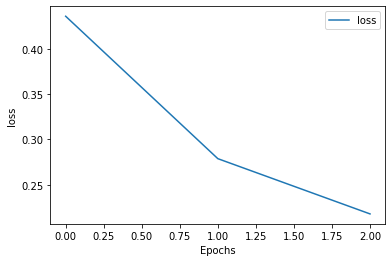

In [19]:
plot_graphs(history, 'loss')